In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename) 

In [2]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MultiHeadAttention 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [3]:
import os
import pandas as pd

BASOPHIL_dirs = [r'/kaggle/input/white-blood-cell-2/wbcv4_no_augmentation_randomRotate/Basophil']

EOSINOPHIL_dirs = [
    r'/kaggle/input/white-blood-cell-2/wbcv4_no_augmentation_randomRotate/Eosinophil'
]

LYMPHOCYTE_dir = [ r'/kaggle/input/white-blood-cell-2/wbcv4_no_augmentation_randomRotate/Lymphocyte']

MONOCYTE_dirs = [
    r'/kaggle/input/white-blood-cell-2/wbcv4_no_augmentation_randomRotate/Monocyte'
]

NEUTROPHIL_dirs = [
    r'/kaggle/input/white-blood-cell-2/wbcv4_no_augmentation_randomRotate/Neutrophil'
]

filepaths = []
labels = []
dict_lists = [BASOPHIL_dirs, EOSINOPHIL_dirs, LYMPHOCYTE_dir, MONOCYTE_dirs, NEUTROPHIL_dirs]
class_labels = ['BASOPHIL','EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
bloodCell_data = pd.concat([Fseries, Lseries], axis=1)
bloodCell_df = pd.DataFrame(bloodCell_data)
print(bloodCell_df.head())
print(bloodCell_df["labels"].value_counts())

                                           filepaths    labels
0  /kaggle/input/white-blood-cell-2/wbcv4_no_augm...  BASOPHIL
1  /kaggle/input/white-blood-cell-2/wbcv4_no_augm...  BASOPHIL
2  /kaggle/input/white-blood-cell-2/wbcv4_no_augm...  BASOPHIL
3  /kaggle/input/white-blood-cell-2/wbcv4_no_augm...  BASOPHIL
4  /kaggle/input/white-blood-cell-2/wbcv4_no_augm...  BASOPHIL
labels
NEUTROPHIL    6231
LYMPHOCYTE    2427
EOSINOPHIL    2132
MONOCYTE      1590
BASOPHIL       602
Name: count, dtype: int64


In [4]:
bloodCell_df.shape

(12982, 2)

In [5]:
train_images, test_images = train_test_split(bloodCell_df, test_size=0.3, random_state=42)
#train_set, val_set = train_test_split(bloodCell_df, test_size=0.2, random_state=42)

#skf = StratifiedKFold(n_split = 5, random_state = 42, shuffle = True) 

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [6]:
image_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.25,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train = image_gen.flow_from_dataframe(dataframe= train_images,x_col="filepaths",y_col="labels",
                                      target_size=(120,120),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=8,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(120,120),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=8,
                                     shuffle= False
                                    )
# val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
#                                     target_size=(120,120),
#                                     color_mode= 'rgb',
#                                     class_mode="categorical",
#                                     batch_size=8,
#                                     shuffle=False
#                                    )

Found 9087 validated image filenames belonging to 5 classes.
Found 3895 validated image filenames belonging to 5 classes.


In [7]:
classes=list(test.class_indices.keys())
print (classes)

['BASOPHIL', 'EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


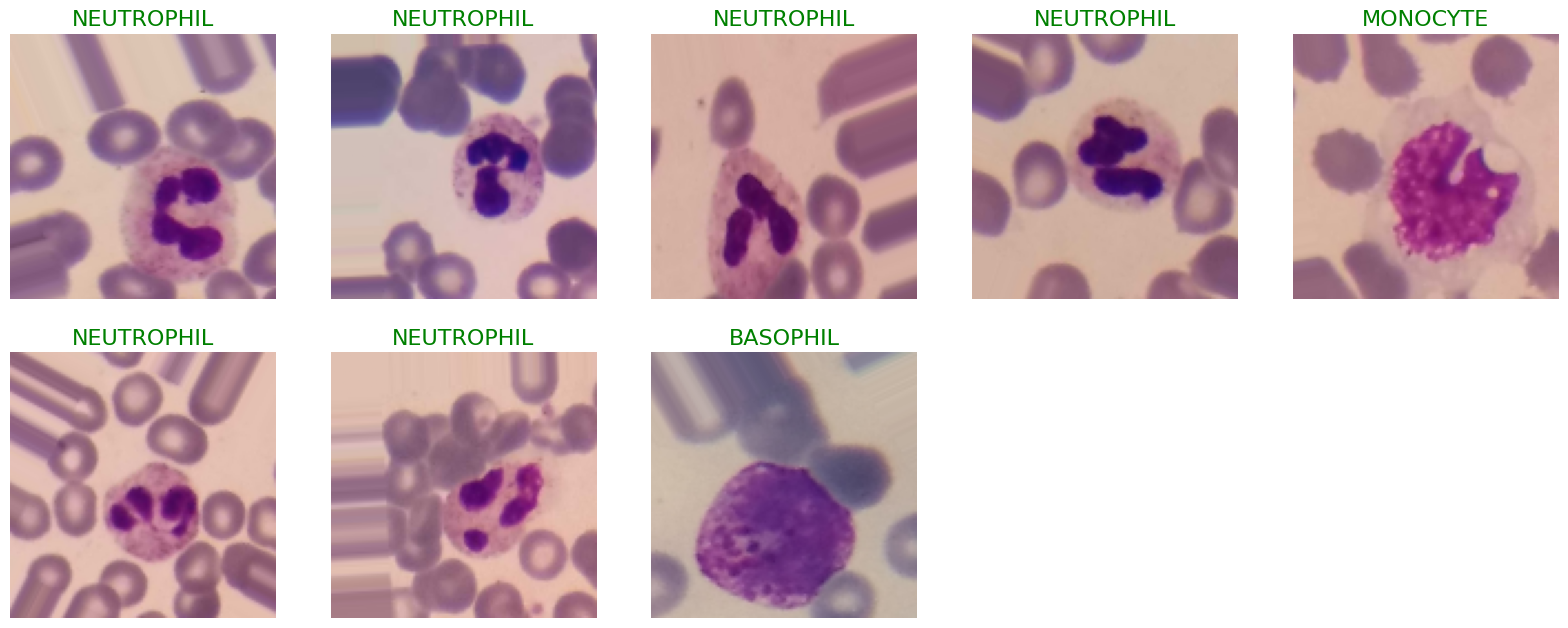

In [8]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()
show_knee_images(test)

In [9]:
# Function to create the model
from tensorflow.keras import layers, Model
def create_model():
    inputs = keras.Input(shape=(120, 120, 3))

    # Initial convolutional layers
    x = layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu')(inputs)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(pool_size=(3, 3))(x)

    x = layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same")(x)
    x = layers.BatchNormalization()(x)

    # Reshape for Multi-Head Attention
    x = layers.Reshape((256, -1))(x)

    # Multi-Head Attention layer
    attention_output = layers.MultiHeadAttention(num_heads=6, key_dim=64)(x, x)
    x = layers.LayerNormalization()(attention_output)

    # Flatten and dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Output layer for 5 classes
    outputs = layers.Dense(5, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    
   
    return model


In [10]:
model = create_model()
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
     )
print("Model input shape:", model.input_shape)
print("Model output shape:", model.output_shape)

Model input shape: (None, 120, 120, 3)
Model output shape: (None, 5)


In [11]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 38, 38,    │     24,704 │ input_layer[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 38, 38,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 38, 38,    │    819,456 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 38, 38,    │      1,024 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 12, 12,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 12, 12,    │    590,080 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 256, 144)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 256, 144)  │    222,480 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 256, 144)  │        288 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 36864)     │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │ 37,749,760 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1024)      │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1024)      │  1,049,600 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1024)      │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 5)         │      5,125 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 40,464,053 (154.36 MB)

 Trainable params: 40,462,773 (154.35 MB)

 Non-trainable params: 1,280 (5.00 KB)

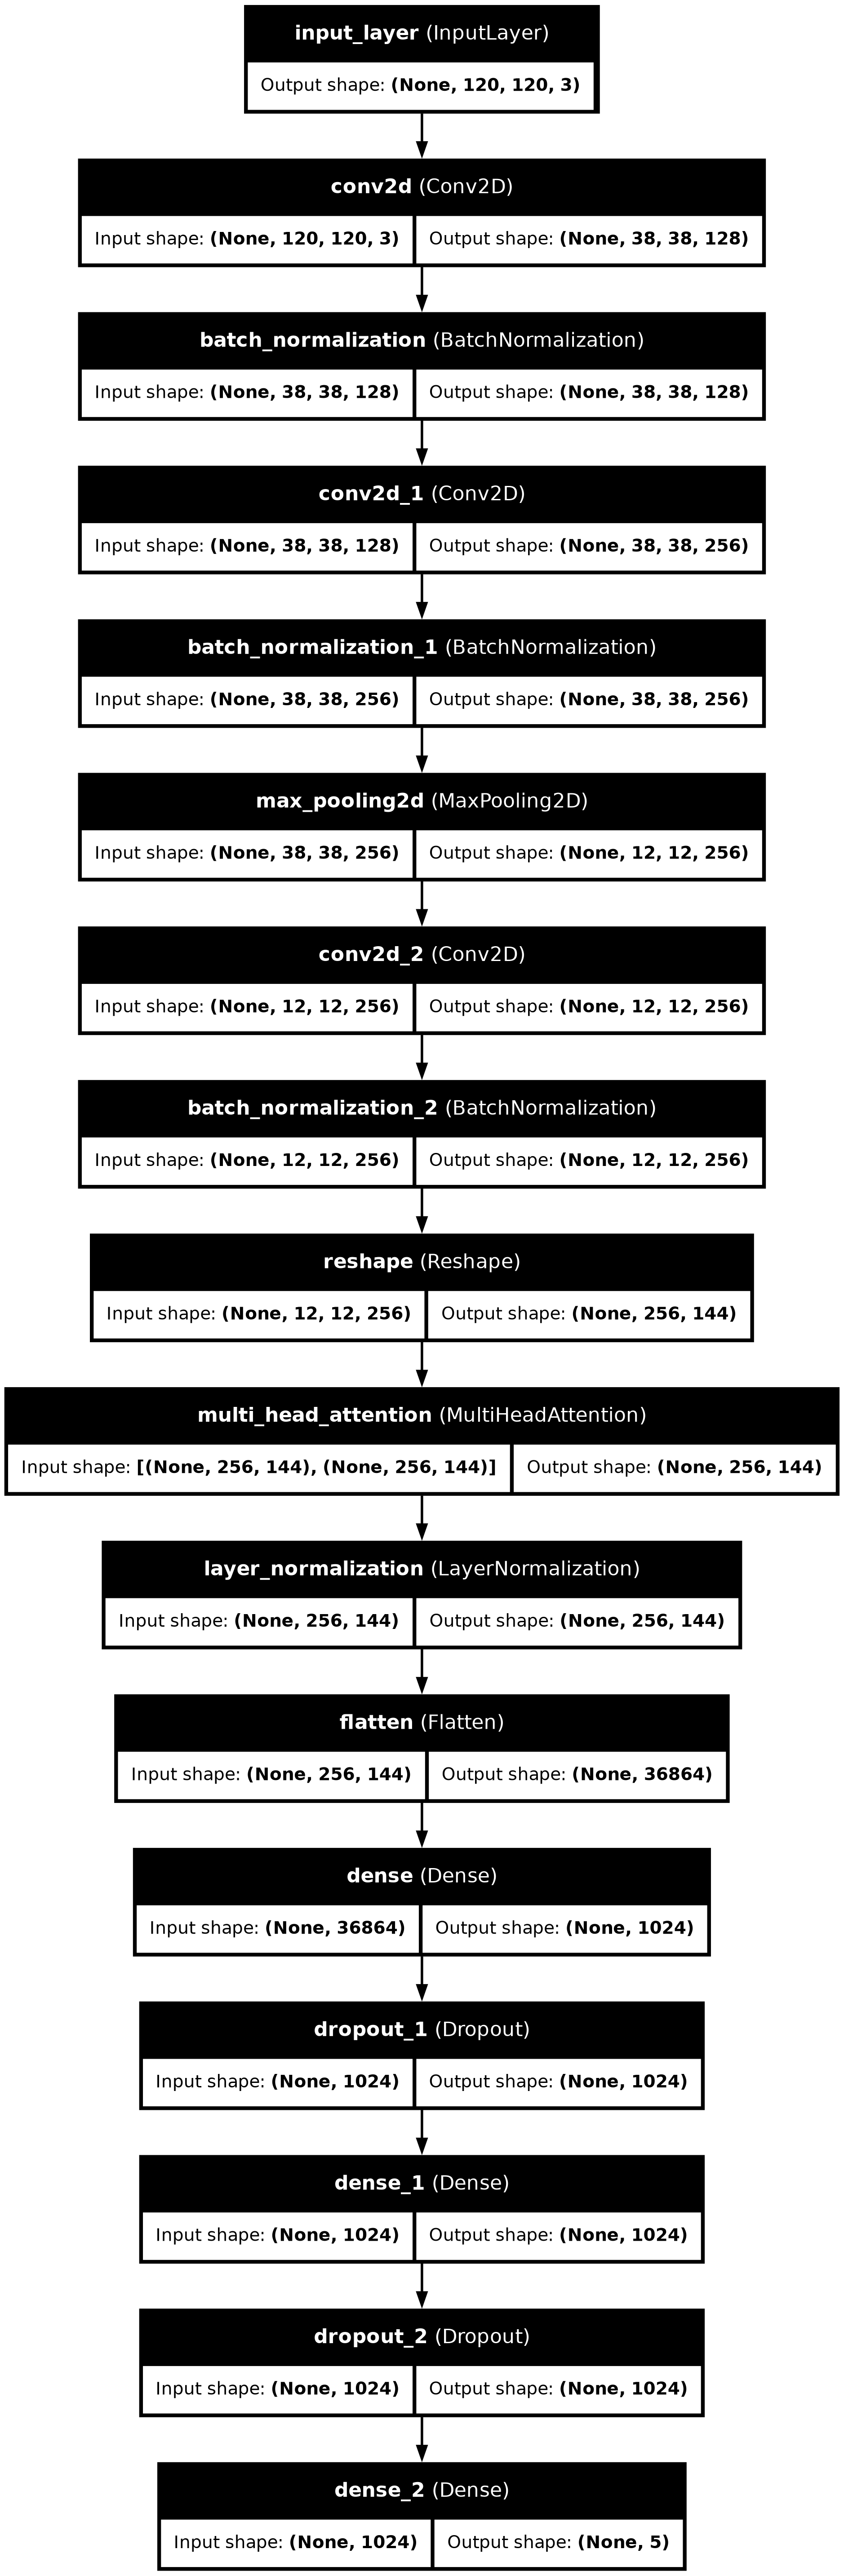

In [12]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [13]:
fold = 1
accuracies = []

In [14]:
history = model.fit(train, epochs=20, validation_data=train, verbose=1)

Epoch 1/20


I0000 00:00:1733905714.288294      68 service.cc:145] XLA service 0x79a5540042e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733905714.288400      68 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   4/1136 ━━━━━━━━━━━━━━━━━━━━ 59s 52ms/step - accuracy: 0.2708 - loss: 1.6447

I0000 00:00:1733905721.083736      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1136/1136 ━━━━━━━━━━━━━━━━━━━━ 138s 114ms/step - accuracy: 0.5774 - loss: 1.0783 - val_accuracy: 0.8712 - val_loss: 0.3832
Epoch 2/20
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 105s 93ms/step - accuracy: 0.8129 - loss: 0.5475 - val_accuracy: 0.9022 - val_loss: 0.2895
Epoch 3/20
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 108s 95ms/step - accuracy: 0.8574 - loss: 0.4468 - val_accuracy: 0.8359 - val_loss: 0.4688
Epoch 4/20
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 115s 101ms/step - accuracy: 0.8799 - loss: 0.3614 - val_accuracy: 0.9124 - val_loss: 0.2411
Epoch 5/20
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 120s 106ms/step - accuracy: 0.8989 - loss: 0.3005 - val_accuracy: 0.8923 - val_loss: 0.3394
Epoch 6/20
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 116s 102ms/step - accuracy: 0.8911 - loss: 0.3245 - val_accuracy: 0.9257 - val_loss: 0.2127
Epoch 7/20
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 112s 98ms/step - accuracy: 0.9150 - loss: 0.2588 - val_accuracy: 0.9512 - val_loss: 0.1447
Epoch 8/20
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 111s 98ms/step - accuracy: 0.9149 

In [15]:
model.evaluate(test, verbose=1)

487/487 ━━━━━━━━━━━━━━━━━━━━ 32s 67ms/step - accuracy: 0.9561 - loss: 0.1251


[0.1273774951696396, 0.9548138380050659]

In [16]:
history1 = model.fit(train, epochs=1, validation_data=train, verbose=1)

1136/1136 ━━━━━━━━━━━━━━━━━━━━ 107s 94ms/step - accuracy: 0.9438 - loss: 0.1639 - val_accuracy: 0.9761 - val_loss: 0.0706


In [17]:
model.evaluate(test, verbose=1)

487/487 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - accuracy: 0.9692 - loss: 0.0961


[0.097929447889328, 0.9702182412147522]

In [18]:
model.save("Blood Cell.h5")

In [19]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

487/487 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step


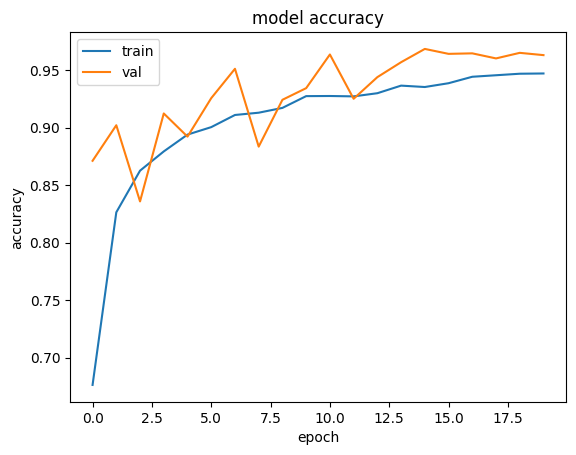

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

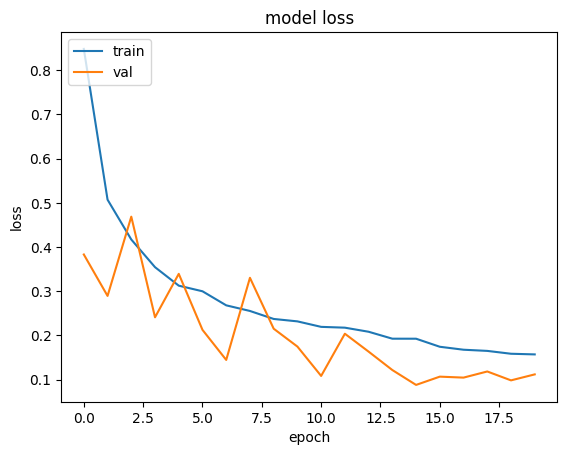

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

    BASOPHIL       0.99      0.99      0.99       186
  EOSINOPHIL       0.98      0.95      0.96       633
  LYMPHOCYTE       0.98      0.95      0.96       746
    MONOCYTE       0.94      0.94      0.94       488
  NEUTROPHIL       0.97      0.99      0.98      1842

    accuracy                           0.97      3895
   macro avg       0.97      0.96      0.97      3895
weighted avg       0.97      0.97      0.97      3895

Accuracy of the Model: 96.9%


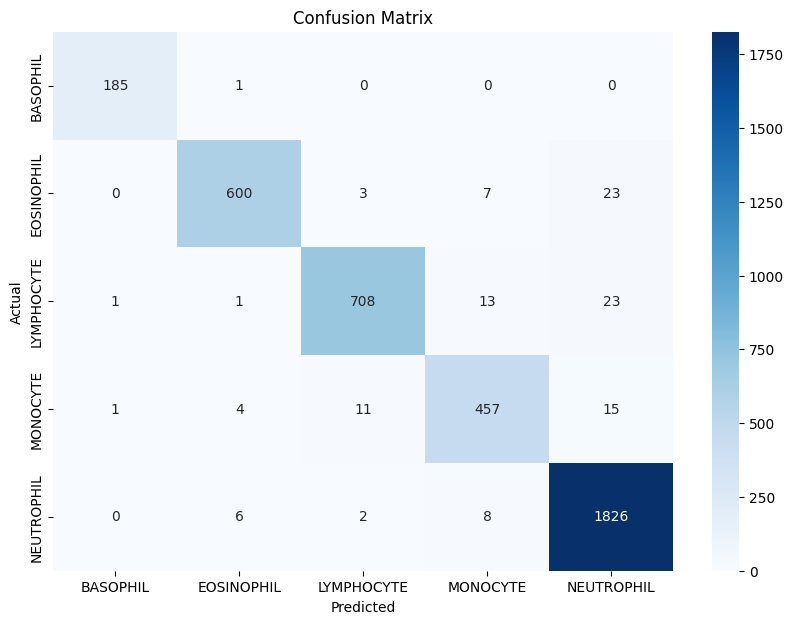

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['BASOPHIL','EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()